# Phonon

<a id='section_1'></a>

## 1. Introduction

### 1.1 フォノン (phonon)とは

フォノンは、一言で表すと**周期境界条件をもつ結晶における振動モード**です。

詳細の説明に入る前に、Phononを目で見て感覚を掴むため[こちらのサイト](http://henriquemiranda.github.io/phononwebsite/phonon.html)を見てましょう。

<figure style="width:600px">
    <img src="../assets/phonon-0-play-with-phonon.gif"/>
    <figcaption>フォノンのアニメーション表示。<a href="http://henriquemiranda.github.io/phononwebsite/phonon.html">http://henriquemiranda.github.io/phononwebsite/phonon.html</a> より。</figcaption>
</figure>

上記Websiteへ行く -> 左上の`materials` という表から `Si` を選択 -> 右図の"フォノン分散図"から適当に点をクリックしてみましょう。
すると、真ん中のシリコン結晶におけるシリコン原子それぞれが周期的な動きをしていることが確認できます。そして、全体として片側から反対側に波が伝わるような動きとなっていることが見て取れます。

このような結晶における振動を格子振動と呼びます。格子振動は振動数が非常に大きくなるため、通常は量子力学的な効果を考慮して取り扱われます。格子振動に量子効果を含めたものにはフォノンという名前がついています。ただし、以下の説明では複雑さを避けるため、格子振動とフォノンは特別に用語を区別せずに解説しています。より詳しくは末尾のAppendixや固体物理学の教科書を参考にしてください。

波の伝播する方向は**波数ベクトル** $\vec q$ で表されます。
フォノンの解析を行う際に重要な問題は、ある波数ベクトル $\vec q$ に対し、どのような振動モードが許されているのか、その振動モードにおける原子の振動数がどうなるかを求めることです。

フォノンは[準粒子](https://ja.wikipedia.org/wiki/%E6%BA%96%E7%B2%92%E5%AD%90)であり、エネルギー $E$と運動量 $\mathbf{p}$をもちます。
固体中のフォノンは熱物性や音波特性に深い関わりがあります。例えば、フォノンの励起は内部エネルギー $U$の増加に寄与したり、フォノンの輸送は音や熱の伝導を引き起こします。このように、フォノン解析は固体の性質を探る上で重要なシミュレーションツールとなります。

### 1.2 フォノン振動数の計算方法

前章で紹介した振動解析と同様、フォノンも調和振動子近似を用いて計算されます。
ただし違いとして、各原子はUnit cellをまたいで向こうにいる原子とも相互作用をします。
周期境界条件を考慮して、結晶構造から微小変位をさせた系のポテンシャルエネルギーは以下のように表されます。

$$ V(\mathbf{r}) \approx V(\mathbf{r_0}) +　\frac{1}{2} \sum_{ij} \frac{\partial^2 V(\mathbf{r_0})}{\partial r_i^a \partial r_j^b} \Delta \mathbf{r}_i^a \Delta \mathbf{r}_j^b $$

ここで、$r_i^a$ $a$番目のスーパーセルに属する、$i$番目の原子の座標です。結晶における力定数マトリクス (前章で紹介) は$3NM \times 3NM$ 行列となります。 $N$ はユニットセルの原子数、 $M$ はユニットセルの数です。 このため、力定数マトリクスはとても大きな行列となります。

特定の振動モードにおける、各原子の平衡点からの変位 $u$は次の平面波のような形を持つと仮定します。

$$ u(\vec R, t) = A e^{ \vec{q} \vec{R} -i\omega_{m} t} $$

詳細は省きますが、この仮定のもとで実空間における離散フーリエ変換を適用することで、　大きな力定数マトリクスを$3N \times 3N$のdynamical matrixに変換することができます。
Dynamical matrixは波数ベクトル$\vec q$に依存しており、その固有値と固有ベクトルがフォノンの振動数と振動モードに相当します。
詳細な導出については、末尾の[appendix](#section_5.1)を参照ください。

次章では、フォノンの計算をMatlantis上で提供しているライブラリである`matlantis-features`を用いて行いながら、フォノンの重要なコンセプトを説明します。

<a id='section_2'></a>

## 2. Siでのフォノン計算

### 2.1 構造準備

ここでは、フォノン計算の例としてシリコン結晶を用います。
まずは構造緩和を行います。
フォノン分散を計算する時は、その結晶構造の基本単位胞 (primitive cell)を用いることが多いです。セル内を最小原子で構成できるためです。

In [1]:
import numpy as np
np.set_printoptions(precision=3)

from ase.build import bulk
from ase.optimize import BFGS
from ase.constraints import ExpCellFilter

import pfp_api_client
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode

estimator = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL, model_version="v2.0.0")
calculator = ASECalculator(estimator)
atoms = bulk("Si")
atoms.calc = calculator

exp = ExpCellFilter(atoms)
BFGS(exp).run(fmax=0.01)

      Step     Time          Energy         fmax
BFGS:    0 04:21:16       -9.092463        0.4849
BFGS:    1 04:21:16       -9.097616        0.0140
BFGS:    2 04:21:16       -9.097620        0.0002


True

### 2.2 力定数マトリクスの計算

振動解析同様、フォノンの振動数計算には力定数マトリクスが必要です。
この力定数マトリクスは、`ForceConstantFeature`で計算されます。

Siの基本単位胞は2原子が含まれています。
この基本単位胞をたくさん繰り返したスーパーセル構造を作成することが精度の良い結果を得るために必要です。
力定数マトリクスの各成分 $\frac{\partial^2 V(\mathbf{r_0})}{\partial r_i^a \partial r_j^b} $ は、$a$番目のユニットセルの$i$番目の原子と $b$番目のユニットセルの$j$番目の原子との距離で減衰していきますが、スーパーセルが十分大きい場合にのみ力定数マトリクスで無視できないような要素は含まれているとみなせます。

本チュートリアルでは、 Si結晶を 10x10x10 に拡張して計算を行います。

`matlantis-features`の`ForceConstantFeature`を用いて計算します。

In [2]:
from matlantis_features.features.phonon import ForceConstantFeature

fc = ForceConstantFeature(
    supercell = (10,10,10),
    delta = 0.1,
)
force_constant = fc(atoms)
print(force_constant.force_constant.shape)

(1000, 6, 6)


計算結果として得られる力定数マトリクス $C$ は 1000x6x6 のshapeを持つtensorとなります。

In [3]:
print(force_constant.force_constant[1])

[[-0.221 -0.215 -0.054  0.005 -0.01   0.051]
 [-0.215 -0.221 -0.054 -0.01   0.005  0.051]
 [ 0.054  0.054  0.396  0.051  0.051 -0.2  ]
 [-3.086 -2.142  2.142 -0.221 -0.215  0.054]
 [-2.142 -3.086  2.142 -0.215 -0.221  0.054]
 [ 2.142  2.142 -3.086 -0.054 -0.054  0.396]]


`force_constant.force_constant[1]` は 6x6 のtensorです。<br/>
これは、1つめと2つめのユニットセルにおける力定数 $C^{1,2}$、すなわち $\frac{\partial^2 V(\mathbf{r_0})}{\partial r_i^1 \partial r_j^2} $です。<br/>
前章の振動解析同様、力定数 $C^{1,2}$は有限差分法で近似計算されています。

$$C^{1,2}[i,j]=\frac{\partial^2 V(\mathbf{r_0})}{\partial r_i^1 \partial r_j^2} \approx \frac{F(\mathbf{r_0} + \Delta r_i^1)_j^2 - F(\mathbf{r_0})_j^2}{|\Delta{r_i^1}|} $$

今回は、10x10x10 のスーパーセルを用いているため、ユニットセルの組み合わせである1000x1000 の数だけ 6x6 matrix が得られるべきです。
しかし、結晶の並進対称性を考慮し、$C^{a,b} = C^{0, b-a}$ となることを利用することで、力定数マトリクスを 1000x6x6 tensorで表すことができます。

### 2.3 Dynamical matrixの計算

分子の振動数は力定数マトリクス$C$の対角化で得られましたが、結晶の振動数は実空間の力定数マトリクスを離散フーリエ変換したdynamical matrix $D_{\vec q}$ の固有値として得られます。
Dynamical matrixへの変換の際に、波数ベクトル $\vec q$ というパラメータが追加で導入されます。

ここでは、`matlantis-features`の`PhononFreqency`を用いて、シリコン結晶の波数ベクトル $\vec q = [0.1, 0.0, 0.0]$ に対応するdynamical matrix を計算してみます。

In [4]:
from matlantis_features.features.phonon.utils import PhononFrequency

phonon_frequency = PhononFrequency(
    force_constant.force_constant, force_constant.supercell, force_constant.unit_cell_atoms
)
dynamic_matrix = phonon_frequency._dynamic_matrix_q(np.array([0.1, 0.0, 0.0])).real
print("Dynamical matrix of q=[0.1, 0.0, 0.0]:")
print(dynamic_matrix)

Dynamical matrix of q=[0.1, 0.0, 0.0]:
[[ 0.437 -0.003 -0.003 -0.413 -0.012 -0.012]
 [-0.003  0.437  0.003 -0.012 -0.413  0.012]
 [-0.003  0.003  0.437 -0.012  0.012 -0.413]
 [-0.413 -0.012 -0.012  0.437 -0.003 -0.003]
 [-0.012 -0.413  0.012 -0.003  0.437  0.003]
 [-0.012  0.012 -0.413 -0.003  0.003  0.437]]


Dynamical matrixは 6x6 の対称行列となっています。これは、力定数マトリクス $C$ から以下の式の計算により得られています。

$$
\tilde{D}_{\vec{q}}[k\alpha, k'\beta] = \frac{1}{\sqrt{M_k M_{k'}}} \tilde{C}(\vec{q})[k\alpha, k'\beta] 
$$
$$ \tilde{C}_{\vec{q}}[k\alpha, k'\beta] = \sum_{b} {\left( \frac{\partial ^{2} E}{\partial{u_{k}^{a\alpha}} \partial{u_{k'}^{b\beta}}} \right) e^{i\vec{q}(\vec{R_b} - \vec{R_a})}} = \sum_{b} {C^{0,b}[k\alpha, k'\beta] e^{i\vec{q}(\vec{R_b} - \vec{R_a})}}$$

その後、この行列を対角化することで固有値・固有ベクトルを得ます。
分子の振動解析と似たように、固有値が振動数に対応し、固有ベクトルはそのフォノンモードにおける原子の変位と関連付けられます。
式の導出など、詳細は[appendix](#section_5.1)を参照ください。

それでは、シリコン結晶の $\vec q = [0.1, 0.0, 0.0]$ におけるフォノンの振動数を計算してみましょう。

In [5]:
frequency, eigenvector = phonon_frequency._frequency_mode_q(np.array([0.1, 0.0, 0.0]), return_mode=True)
for i in range(6):
    print(f"Band {i}")
    print(f"    Frequency: {frequency[i]:.3f} meV")
    print(f"    Eigenvector:")
    print(eigenvector[i].real)

Band 0
    Frequency: 5.646 meV
    Eigenvector:
[[-0.068  0.04  -0.107]
 [-0.068  0.04  -0.108]]
Band 1
    Frequency: 5.648 meV
    Eigenvector:
[[-0.082 -0.099  0.017]
 [-0.081 -0.098  0.017]]
Band 2
    Frequency: 10.978 meV
    Eigenvector:
[[ 0.073 -0.073 -0.073]
 [ 0.077 -0.077 -0.077]]
Band 3
    Frequency: 59.794 meV
    Eigenvector:
[[-0.073  0.072  0.073]
 [ 0.077 -0.077 -0.077]]
Band 4
    Frequency: 59.954 meV
    Eigenvector:
[[-0.005 -0.044  0.039]
 [ 0.009  0.049 -0.039]]
Band 5
    Frequency: 59.955 meV
    Eigenvector:
[[-0.06   0.041 -0.102]
 [ 0.062 -0.04   0.102]]


<b>波数ベクトル $\vec q$</b>

フォノンの計算では、波数ベクトル $\vec q$ が導入されました。
この波数ベクトルの物理的な意味は、その振動モードの伝播する方向と関連します。
また、理論的に波数ベクトル $\vec q$ は第一[ブリルアンゾーン](https://ja.wikipedia.org/wiki/%E3%83%96%E3%83%AA%E3%83%A5%E3%82%A2%E3%83%B3%E3%82%BE%E3%83%BC%E3%83%B3) (first Brillouin zone)の中に制限できることが示せます (詳細はappendixを参照)。

ここでは、`get_brillouin_zone_3d`関数を使い、シリコン結晶における第一ブリルアンゾーンを可視化してみます。<br/>
Wikipedia上の以下の画像と比較してみてください

<figure style="width:300px">
    <img src="https://upload.wikimedia.org/wikipedia/commons/c/c1/Brillouin_Zone_%281st%2C_FCC%29.svg"/>
    <figcaption>対称性ラベルを付した面心立方格子構造(FCC構造)の第一ブリルアンゾーン。<br/>
        <a href="https://en.wikipedia.org/wiki/Brillouin_zone">https://en.wikipedia.org/wiki/Brillouin_zone</a> より。
    </figcaption>
</figure>



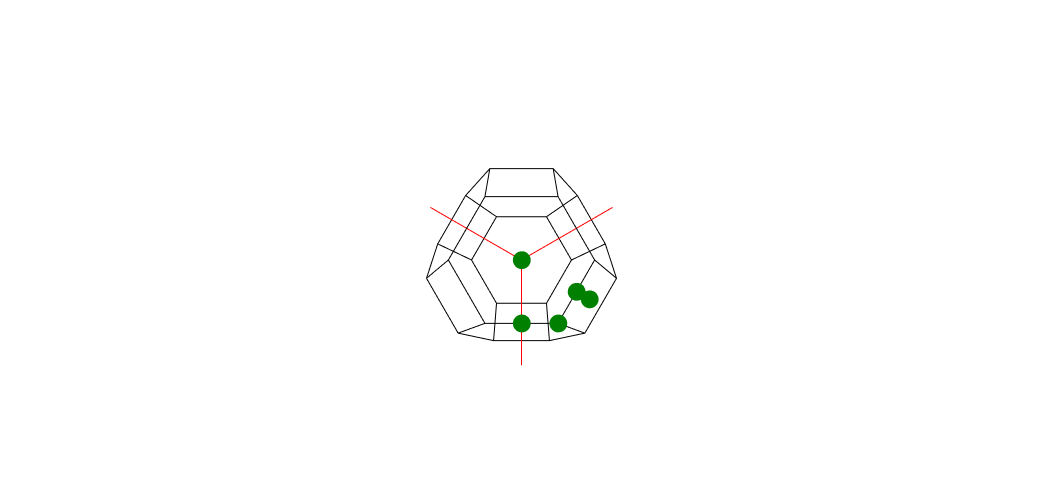

In [7]:
from matlantis_features.utils.visual_utils.brillouin_zone import get_brillouin_zone_3d

fig = get_brillouin_zone_3d(atoms.cell, show_reciprocal_basis=True, show_special_k_points=True)
fig.update_layout(width=600, height=500)

シリコン結晶はFCC構造となっており、その第一ブリルアンゾーンは[切頂八面体](https://ja.wikipedia.org/wiki/%E5%88%87%E9%A0%82%E5%85%AB%E9%9D%A2%E4%BD%93) (truncated octahedron)となります。
緑の点で示されているのが対称性の高い点で、例えば [0.375, 0.375, 0.75]の点は"K" というラベルが付与されています。上記図をマウスオーバーするとラベルが表示されるので確認してみてください。
第一ブリルアンゾーンの中心は特に$\Gamma$ (or G)点 (ガンマ点)と名付けられています。

許されるすべてのフォノンの振動数を求めるには、第一ブリルアンゾーン内のすべての$\vec q$点にて計算を行う必要があります。
しかし実際には、第一ブリルアンゾーン内の代表的な対象性の高い点をつなぐパス(例えば$\Gamma$点とK点を結ぶ直線など)上でのみ計算を行って可視化をして確認するということが慣例的に行われています。
対象性の高い点をつないだパス上のフォノンの振動数のプロットは、フォノン分散曲線 (フォノン分散関係・フォノンバンド)と呼ばれます。

ここでは、`matlantis-features`の`PostPhononBandFeature`を用いて、シリコン結晶のフォノン分散を計算します。

### 2.4 フォノン分散の計算

`PostPhononBandFeature`は、`ForceConstantFeature`の計算結果を利用します。
対象性の高い点のパスを指定する際はラベルの列を指定します。
ここでは、G -> X -> W -> K -> G -> L -> U -> W -> L -> K と U -> X というパスでのフォノン振動数を計算してフォノン分散を得ています。

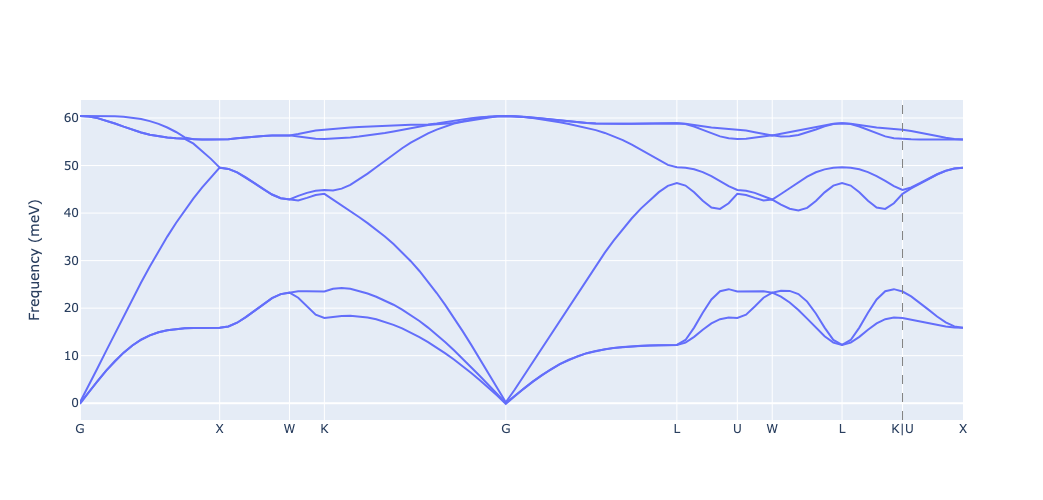

In [8]:
from matlantis_features.features.phonon import PostPhononBandFeature

band = PostPhononBandFeature()
band_results = band(
    force_constant, 
    labels = ['G', 'X', 'W', 'K', 'G', 'L', 'U', 'W', 'L', 'K', '|', 'U', 'X'], 
    total_n_kpts = 100,
)
fig = band_results.plot()
fig.update_layout(width=700, height=500)

上記の図をみると、シリコンのフォノン分散では６つの線が存在している事がわかります(場所によっては2本の線が縮退して1本に見える箇所もあります)。
つまり、各波数ベクトルに対して６つの振動モードがあるということを表しています。

これらの振動モードは、光学モード(optical)と音響モード(acoustic)に分類できます。
さらに、その振動モードの伝播方向により、縦方向(longitudinal)と横方向(transverse)にも分類されます。

次は実際にこの分類を行っていきます。

### 2.5 フォノンモード

**光学モード・音響モード**

上記で説明したように、各波数ベクトル $\vec q$ に対して $3N$ 個の振動数を得ることができます。
分散曲線には$3N$個の線が存在します。
これは、$3$つの音響モードと、$3N-3$つの光学モードに分けられます。

音響モードは以下のような特徴を持ちます。
 - 音響モードは低い振動数を持つ。
 - 音響モードの振動数 $\omega$ は、ガンマ点で0となる。$\frac{\partial \omega} {\partial q}$は音速を与える。
 - 音響モードの$q=0$における格子振動を確認すると、格子全体が動いていることが見て取れます。これは弾性波と類似しています。

光学モードは以下のような特徴を持ちます。
 - 光学モードは高い振動数を持つ。
 - 近接する原子同士は逆方向に動きあう。
 - 複数の元素を含む結晶、例えばNaClなどでは、カチオンとアニオン ([イオン](https://ja.wikipedia.org/wiki/%E3%82%A4%E3%82%AA%E3%83%B3#%E3%82%A4%E3%82%AA%E3%83%B3%E3%81%AE%E7%A8%AE%E9%A1%9E)参照)の間でおこる振動により[ダイポールモーメント](https://ja.wikipedia.org/wiki/%E5%8F%8C%E6%A5%B5%E5%AD%90)が変化します。このダイポールモーメントが外場の電磁波と相互作用します。そのため、光学モードと呼ばれます。

In [9]:
from ipywidgets import HBox
from ase.visualize import view
from matlantis_features.features.phonon import PostPhononModeFeature
from pfcc_extras.visualize.povray import traj_to_apng

mode = PostPhononModeFeature()
mode_results = mode(
    force_constant,
    k_point=(0.1, 0.0, 0.0),
    repeat_of_cell=(4, 4, 4),
    n_images=30,
    amplitude=5.0
)

for i in range(6):
    traj_to_apng(mode_results.trajectories[i], f"output/vib.{i}.png", rotation="0x,0y,0z", clean=True, n_jobs=16)


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:   22.8s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:   22.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:   22.3s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:   22.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:   22.3s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:   22.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:   22.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:   22.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 co

**Acoustic vibration modes**
<div style="clear:both;display:table">
<figure style="width:30%;float:left;margin:1px">
  <img src="./output/vib.0.png" alt="mode0">
  <figcaption>Mode #0</figcaption>
</figure>
<figure style="width:30%;float:left;margin:1px">
  <img src="./output/vib.1.png" alt="mode1">
  <figcaption>Mode #1</figcaption>
</figure>
<figure style="width:30%;float:left;margin:1px">
  <img src="./output/vib.2.png" alt="mode2">
  <figcaption>Mode #2</figcaption>
</figure>
</div>

**Optical vibration modes**
<div style="clear:both;display:table">
<figure style="width:30%;float:left;margin:1px">
  <img src="./output/vib.3.png" alt="mode3">
  <figcaption>Mode #3</figcaption>
</figure>
<figure style="width:30%;float:left;margin:1px">
  <img src="./output/vib.4.png" alt="mode4">
  <figcaption>Mode #4</figcaption>
</figure>
<figure style="width:30%;float:left;margin:1px">
  <img src="./output/vib.5.png" alt="mode5">
  <figcaption>Mode #5</figcaption>
</figure>
</div>

可視化してみると、Mode 0, 1, 2の原子は全体が同じ方向に動いている一方、Mode 3, 4, 5では原子同士が相互に振動していることが見て取れます。
低い周波数の3つのモードが音響モード、残りが光学モードに対応していることがわかります。

**横(Transverse)モードと縦(Longitudinal)モード**

フォノン分岐は原子の振動の向きと波数ベクトルの向きとの関係により横モードと縦モードに分けられます。
横モードでは原子の変位は波数ベクトル $\vec q$ に対して垂直なります。
縦モードでは、原子の変位が波数ベクトル $\vec q$ の方向に対して並行になります。

以下のように計算で横モード・縦モードを確認することもできます。

In [10]:
reciprocal_basis = atoms.cell.reciprocal()
q_real = reciprocal_basis.dot(np.array([0.1, 0, 0]))

def get_angles(eigenvector, q_real):
    return np.arccos(eigenvector.dot(q_real) / np.linalg.norm(eigenvector, axis=1) / np.linalg.norm(q_real))

for i in range(6):
    angles = get_angles(eigenvector[i].real, q_real)
    print(f"Band {i}:")
    print(f"    Angles between q and eigenvectors:", angles)

Band 0:
    Angles between q and eigenvectors: [1.571 1.571]
Band 1:
    Angles between q and eigenvectors: [1.571 1.571]
Band 2:
    Angles between q and eigenvectors: [3.141 3.141]
Band 3:
    Angles between q and eigenvectors: [2.376e-03 3.139e+00]
Band 4:
    Angles between q and eigenvectors: [1.581 1.56 ]
Band 5:
    Angles between q and eigenvectors: [1.572 1.569]


波数ベクトル$\vec{q}$と固有ベクトルが並行となっているBand 2, 3は縦モード<br/>
波数ベクトル$\vec{q}$と固有ベクトルが垂直となっているBand 0, 1, 4, 5は横モードであることが確認できます。

まとめると、シリコン結晶におけるフォノンの6分岐は以下のように分類できます。

- Transverse acoustic branch   (TA): branch 0 and 1
- Longitudinal acoustic branch (LA): branch 2
- Transverse optic branch      (TO): branch 4 and 5
- Longitudinal optic branch    (LO): branch 3

### 2.6 フォノンの状態密度 (Phonon DOS)

フォノンの分散関係は物性値に関する情報を与えてくれますが、3次元の波数空間上の非自明な関数です。

代わりに、それぞれの振動モードにおけるエネルギーごとに集約をして、その物質中にどのようなモードが存在するかを簡易に表す方法があります。
これをフォノンの状態密度(Phonon DOS: density of states)と呼び、$\omega$ から $\omega+d\omega$の間に存在する振動モードの数として以下のように定義されます。

$$D(\omega) = \frac{1} {N} \sum_{m, \vec q} \delta (\omega - \omega_{m, \vec q})$$

ここでは、`PostPhononDOSFeature` を用いて、シリコン結晶のフォノンの状態密度を計算します。

In [11]:
from matlantis_features.features.phonon import PostPhononDOSFeature, plot_band_dos

dos = PostPhononDOSFeature()
dos_results = dos(
    force_constant,
    kpts = [20,20,20],
    freq_min = -5.0,
    freq_max = 70.0,
    freq_bin =  1.0,
    scheme = "mp",
    unit = "meV"
)

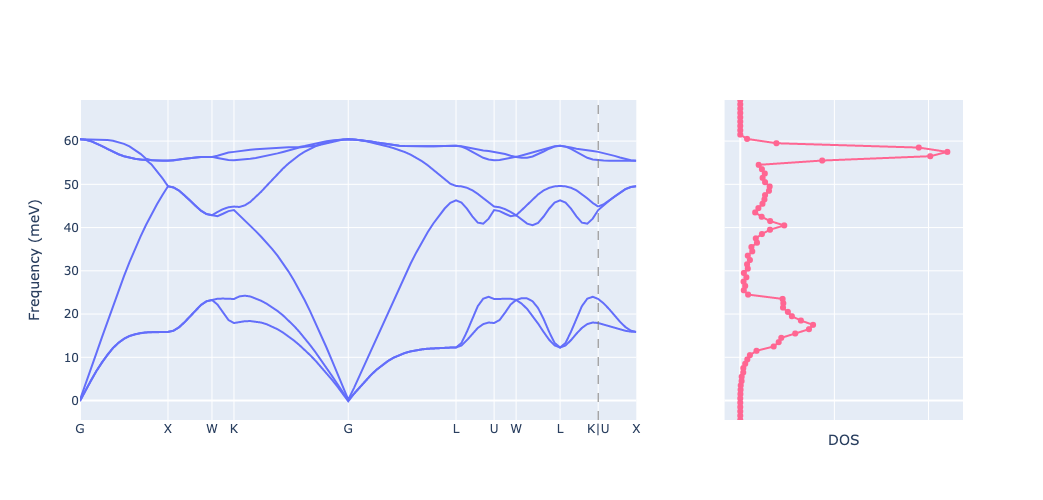

In [12]:
from plotly.offline import iplot

fig = plot_band_dos(band_results, dos_results)
fig.update_layout(width=1000, height=500)
iplot(fig)

上図では、フォノン分散とフォノンの状態密度の図が同時に表示されています。


`PostPhononDOSFeature`では、フォノンの振動数を第一ブリルアンゾーン内の等間隔メッシュ $\vec q$ 上で計算しています。
メッシュのとり方は、Monkhorst-Pack法とGamma-centered法がよく使われます。
上図では、$20 \times 20 \times 20$ Monkhorst-Pack style gridが使用されています。
フォノンの状態密度に関する詳細はappendixをご参照ください。

### 2.7 熱物性値

固体の熱物性値はフォノン分散と密接な関係にあります。
フォノンの状態密度がわかれば、以下の式により、比熱 $C_V$・エントロピー $S$・内部エネルギー $U$・ヘルムホルツ自由エネルギー $A$は計算が可能です。

$$C_V = \int_{0}^{\infty} d {\omega} D(\omega) \; k_B\left( \frac{\hbar \omega}{k_B T} \right)^2 \frac{e^{\frac{\hbar \omega}{k_B T}}}{\left( e^{\frac{\hbar \omega}{k_B T}} - 1 \right)^2}$$

$$
S = \int_{0}^{\infty} d {\omega} D(\omega) \; \left[ ln \left( \frac {1}{e^{\frac{\hbar \omega}{k_B T}}-1} + 1  \right ) \left( \frac {1}{e^{\frac{\hbar \omega}{k_B T}}-1} + 1  \right ) - ln \left( \frac {1}{e^{\frac{\hbar \omega}{k_B T}}-1}  \right ) \left( \frac {1}{e^{\frac{\hbar \omega}{k_B T}}-1} \right ) \right]
$$

$$ U = \int_{0}^{\infty} d {\omega} D(\omega) \; \left[ \frac{\hbar \omega}{2} + \frac {\hbar \omega}{e^{\frac{\hbar \omega}{k_B T}} -1} \right] $$

$$A = \int_{0}^{\infty} d {\omega} D(\omega) \; \left[ \frac{\hbar \omega}{2} + k_BT ln \left( 1-e^{-\frac{\hbar \omega}{k_BT}} \right) \right]$$

[Note]

量子効果を含めたフォノンは離散的なエネルギーしかとらないため、温度の依存性が古典的な格子振動と変わることが知られています。そのため上記の式に量子効果と関わる物理定数である[ディラック定数](https://ja.wikipedia.org/wiki/%E3%83%87%E3%82%A3%E3%83%A9%E3%83%83%E3%82%AF%E5%AE%9A%E6%95%B0)$\hbar$が登場しています。

Matlantis上では `PostPhononThermochemistryFeature` を用いることで上記の計算が可能です。
`PostPhononDOSFeature`同様、波数ベクトル$\vec q$のメッシュの切り方を定義する必要があります。

`PostPhononThermochemistryFeature`は力定数マトリクスからフォノンの状態密度を計算し、上記式を用いて熱物性値を計算します。

In [13]:
from matlantis_features.features.phonon import PostPhononThermochemistryFeature

thermo = PostPhononThermochemistryFeature()
thermo_results = thermo(
    force_constant,
    kpts = [20, 20, 20],
    tmin = 0.0,
    tmax = 1000.0,
    tstep = 10.0,
    scheme = "mp",
)

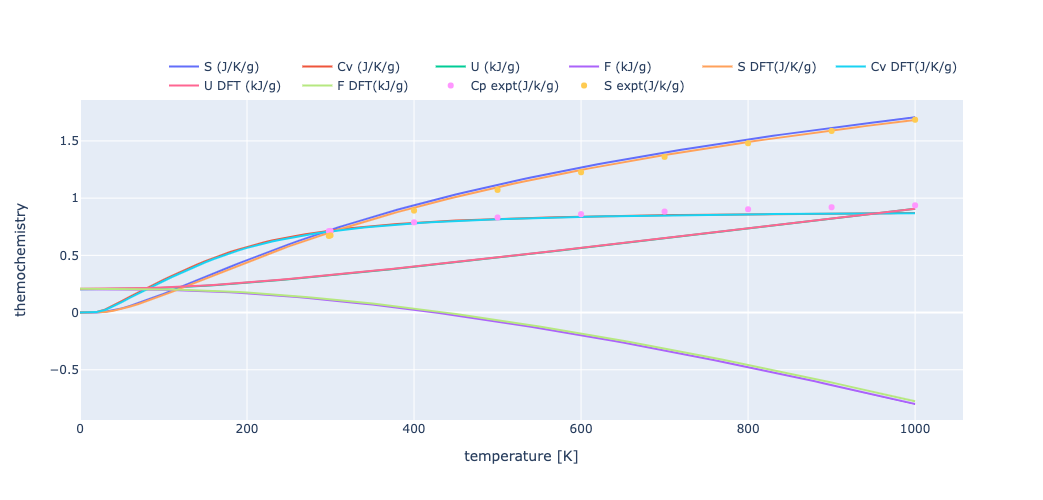

In [14]:
import pandas as pd
import plotly.graph_objects as go

thermo_dft = pd.read_csv("../assets/Si_thermo_dft.csv")
thermo_expt = pd.read_csv("../assets/Si_thermo_expt.csv")

fig = thermo_results.plot()
fig.add_trace(
    go.Scatter(
        x = thermo_dft["T"].loc[:100],
        y = thermo_dft["entropy"].loc[:100] / 28.09 / 2.,
        name = "S DFT(J/K/g)"
    )
)
fig.add_trace(
    go.Scatter(
        x = thermo_dft["T"].loc[:100],
        y = thermo_dft["cv"].loc[:100] / 28.09 / 2.,
        name = "Cv DFT(J/K/g)"
    )
)
fig.add_trace(
    go.Scatter(
        x = thermo_dft["T"].loc[:100],
        y = thermo_dft["internal_energy"].loc[:100] / 28.09 / 2./1000.,
        name = "U DFT (kJ/g)"
    )
)
fig.add_trace(
    go.Scatter(
        x = thermo_dft["T"].loc[:100],
        y = thermo_dft["helmholtz_free_energy"].loc[:100] / 28.09 / 2./1000.,
        name = "F DFT(kJ/g)"
    )
)
fig.add_trace(
    go.Scatter(
        x = thermo_expt["T"],
        y = thermo_expt["cp"],
        mode = "markers",
        name = "Cp expt(J/k/g)"
    )
)
fig.add_trace(
    go.Scatter(
        x = thermo_expt["T"],
        y = thermo_expt["entropy"],
        mode = "markers",
        name = "S expt(J/k/g)"
    )
)
fig.update_layout(width=800, height=500)

上図は計算結果のプロットです。計算結果が、[DFTの計算結果](https://materialsproject.org/materials/mp-149/)や、[実験値](https://webbook.nist.gov/cgi/cbook.cgi?ID=C7440213&Units=SI&Mask=2#Thermo-Condensed)と比べてもよく一致していることが確認できます。

DFT calculation results from

A. Jain*, S.P. Ong*, G. Hautier, W. Chen, W.D. Richards, S. Dacek, S. Cholia, D. Gunter, D. Skinner, G. Ceder, K.A. Persson (*=equal contributions)  
The Materials Project: A materials genome approach to accelerating materials innovation
APL Materials, 2013, 1(1), 011002.  
[doi:10.1063/1.4812323](http://dx.doi.org/10.1063/1.4812323)  
[[bibtex]](https://materialsproject.org/static/docs/jain_ong2013.349ca3156250.bib)  
Licensed under [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)  

Experiment results from

"Condensed Phase Heat Capacity Data" by Eugene S. Domalski and Elizabeth D. Hearing in NIST Chemistry WebBook, NIST Standard Reference Database Number 69, Eds. P.J. Linstrom and W.G. Mallard, National Institute of Standards and Technology, Gaithersburg MD, 20899, https://doi.org/10.18434/T4D303, (retrieved May, 2022).

<a id='section_3'></a>

## 3. 調和振動子近似の限界

これまでに見てきたように、結晶のフォノン分散・フォノンの状態密度・熱物性値が調和振動子近似から計算できることがわかりました。
しかし、ポテンシャルエネルギー局面の２次以降の項を無視してしまっていることによりうまく扱うことができない物性値も存在します。
代表的なものとして、熱膨張率と熱伝導率が挙げられます。

### 3.1 熱膨張率

熱膨張率はフォノン解析から直接得ることができません。調和振動子近似を用いるということは、近接原子がバネでつながっているモデルを仮定しており、エネルギー局面を局所的に２次関数として扱っています。
現実のポテンシャルエネルギー局面はもちろん２次関数ではありません(前章の図1参照)。
近接原子がバネでつながっている調和振動子近似では、温度を上げても結合長が増えません。結果として、固体の体積も温度により増加するという現象を扱えず、熱膨張率は0となってしまいます。

しかし、熱膨張率は[quasi-harmonic approximation](https://en.wikipedia.org/wiki/Quasi-harmonic_approximation)と呼ばれる、調和振動子近似の拡張系で扱うことが可能です。Quasi-harmonic approximationでは、密度の高い・低い系それぞれでフォノン計算を行っていきます。
体積依存するような物性値である、比熱 (Cp)・ギブス自由エネルギー (G)なども同様に計算することができます。

### 3.2 熱伝導率

フォノンはエネルギーや運動量を持ちます。熱の輸送は結晶内でのフォノンの移動として説明することができます。しかし、フォノン解析は調和振動子近似をもとに行われていることから、フォノンの散乱が無視されてしまいます。つまり、フォノンは別のフォノンと衝突せずに無限に離れた場所まで移動することになり、熱伝導率も無限に大きくなってしまいます。
そのため、単純なフォノン解析では熱伝導率を得ることができません。

熱伝導率を扱うためには、非調和性とフォノン散乱を扱うために、テイラー展開の3次の後まで考慮する必要があります。

$$E(\{\vec{R_{k}^{a}}\}) = E(\{\vec{R_{k,0}^{a}}\}) + \sum_{ak\alpha}{\sum_{bk'\beta}{\frac{1}{2} \left (\frac{\partial^2{E}}{\partial{u_{k}^{a\alpha}} \partial{u_{k'}^{b\beta}}} \right ) }} u_{k}^{a\alpha} u_{k'}^{b\beta} + \sum_{ak\alpha}{\sum_{bk'\beta} \sum_{ck''\gamma} {\frac{1}{3!} \left (\frac{\partial^3{E}}{\partial{u_{k}^{a\alpha}} \partial{u_{k'}^{b\beta}} \partial{u_{k''}^{c\gamma}}} \right ) }} u_{k}^{a\alpha} u_{k'}^{b\beta} u_{k''}^{c\gamma} $$

つまり、3次の力定数である $\frac{\partial^3{E}}{\partial{u_{k}^{a\alpha}} \partial{u_{k'}^{b\beta}} \partial{u_{k''}^{c\gamma}}}$　を計算する必要があります。
格子の熱伝導率を計算する方法としては、real-time approximationなどいくつかの手法が開発されています。

<a id='section_4'></a>

## 4. 参考文献

[1] https://personales.unican.es/junqueraj/JavierJunquera_files/Metodos/Latticedynamics/Lattice-dynamics.pdf

[2] http://www-personal.umich.edu/~sunkai/teaching/Winter_2013/chapter5.pdf

[3] http://staff.ustc.edu.cn/~zqj/posts/LinearTetrahedronMethod/

[4] Otero-De-La-Roza, et. al.  Comput. Phys. Commun. 182, 2232–2248 (2011).

[5] 「固体物理学入門 上・下」 キッテル

[6] 「初歩から学ぶ 固体物理学」 矢口裕之

<a id='section_5'></a>

## 5. Appendix

<a id='section_5.1'></a>

### 5.1 フォノン計算の導出

**Illustration**

<figure style="width:400px">
<img src="../assets/phonon-1-illustration.png"/>
</figure>


式の導出の前に、結晶構造の2次元模式図を示します。各ベクトルの意味は図で示されています。

* $\vec{R^{a}}$: 基準セルの原点からユニットセル$\mathit{a}$の原点へのベクトル
* $\vec{R_{k}^{a}}$: 基準セルの原点からユニットセル$\mathit{a}$の原子$\mathit{k}$へのベクトル
* $\vec{R_{k}}$: 原点から同じセル内の原子$\mathit{k}$へのベクトル

**調和振動子近似 (Harmonic approximation)**

* 前章の振動解析同様、原子が平衡点から微小変位した際のポテンシャルエネルギーは以下のように表されます。

$$E(\{\vec{R_{k}^{a}}\}) = E(\{\vec{R_{k,0}^{a}}\}) + \sum_{ak\alpha}{\sum_{bk'\beta}{\frac{1}{2} \left (\frac{\partial^2{E}}{\partial{u_{k}^{a\alpha}} \partial{u_{k'}^{b\beta}}} \right ) }} u_{k}^{a\alpha} u_{k'}^{b\beta} $$

$\vec {u^a}$ は原子の変位 $\vec {R^a} - \vec {R_0^a}$で、 $\alpha$ と $\beta$ は座標軸x, y, zを表します。

* [Note] 調和振動子近似は平衡点からの微小変位でのみ成り立つ近似です。そのため、フォノン解析で得られる熱物性は低温領域に限られます。

**運動方程式**

* 原子$\mathit{k}$に作用する力はポテンシャルエネルギーの微分として以下のように得られます。

$$\vec{F_{k}^{a\alpha}} = -\frac{E \left( \{R_{k}^{a} \} \right)}{\partial R_{k}^{a\alpha}} = -\frac{E \left( \{R_{k}^{a} \} \right)}{\partial u_{k}^{a\alpha}} = -\sum_{bk'\beta} \left ( \frac{\partial ^{2} E}{\partial{u_{k}^{a\alpha}} \partial{u_{k'}^{b\beta}}} \right ) u_{k'}^{b\beta}$$



* 原子$\mathit{k}$の加速度

$$\vec{a_{k}^{a\alpha}} = \frac{\partial^2 u_{k}^{a\alpha}}{\partial t^2}$$

* よって、運動方程式は以下となります。

$$ M_k \frac{\partial^2 u_{k}^{a\alpha}}{\partial t^2} = -\sum_{bk'\beta} \left ( \frac{\partial ^{2} E}{\partial{u_{k}^{a\alpha}} \partial{u_{k'}^{b\beta}}} \right ) u_{k'}^{b\beta} $$

* 各原子に対して、3 つの運動方程式が得られます(x, y, z軸方向)。 結果、全体では $3N \times M$ 個の方程式となります ($N$ はユニットセル内の原子数、$M$ はユニットセル数)。
* これらは連立方程式として結合しています。ユニットセル$a$ の原子$k$の変位$u_{k}^{a\alpha}(t)$は、他の全ての原子変位$u_{k'}^{b\beta}$に依存します。

**仮定**

* 上記式の解を得るため２つの仮定を導入します。
* 1. $u_{k}^{a\alpha}(t)$ は以下の形式(平面波)で書けるとします。
$$ u_{k}^{a\alpha}(t) = A_{k}^{\alpha} e^{-i\omega t} $$

方程式の解が複数ある可能性を考慮し、添字 $\mathit{m}$でそれぞれの解を表します。

$$ u_{k}^{a\alpha}(t) = A_{k, m}^{\alpha} e^{-i\omega_{m} t} \;\;\;  m={1, 2, ..., 3N} $$

* 2. 周期境界条件を考慮し、解は平面波に似た形式になるとします。

$$ u_{k}^{a\alpha}(t) = A_{k, m \vec{q}}^{\alpha} e^{i \vec{q} \vec{R_a}} e^{-i\omega_{m} t} $$

* 上記の仮定から、方程式の解が新たなパラメータ$\vec{q}$ に依存することになります。これが波数ベクトルとなります。

**方程式を解く**

* 上記仮定から運動方程は以下のように書き換えられます。

$$ M_{k} \omega_{m\vec{q}}^{2} A_{m\vec{q}}^{k\alpha} = \sum_{k'\beta} {\left[ \sum_{b} {\left( \frac{\partial ^{2} E}{\partial{u_{k}^{a\alpha}} \partial{u_{k'}^{b\beta}}} \right) e^{i\vec{q}(\vec{R_b} - \vec{R_a})}} \right] A_{m\vec{q}}^{k'\beta}}$$


* ここで、前章の振動解析同様、$3N \times 3N$行列となる力定数マトリクスを定義します。
しかし、周期境界条件を考慮して、ユニットセル $a$ とユニットセル $b$の間の力定数マトリクスは以下のようになります。

$$
C^{a,b} = \begin{bmatrix}
 & \frac{\partial ^2 E}{\partial u_{0}^{a x} \partial u_{0}^{bx}} & \frac{\partial ^2 E}{\partial u_{0}^{a x} \partial u_{0}^{by}} & ... & \frac{\partial ^2 E}{\partial u_{0}^{a x} \partial u_{N}^{bz}} \\ 
 & \frac{\partial ^2 E}{\partial u_{0}^{a y} \partial u_{0}^{bx}} & \frac{\partial ^2 E}{\partial u_{0}^{a y} \partial u_{0}^{by}} & ... & \frac{\partial ^2 E}{\partial u_{0}^{a y} \partial u_{N}^{bz}} \\
 & ... & ... &  & ...\\ 
 & \frac{\partial ^2 E}{\partial u_{N}^{a z} \partial u_{N}^{bx}} & \frac{\partial ^2 E}{\partial u_{N}^{a z} \partial u_{0}^{by}} & ... & \frac{\partial ^2 E}{\partial u_{N}^{a z} \partial u_{N}^{bz}}
\end{bmatrix}
$$

* 結晶格子の並進移動対称性により、 $C^{a,b} = C^{0, b-a}$ となります。

* ここまでの式を代入すると、運動方程式の [...] 内の部分は、力定数マトリクスの離散フーリエ変換の形になっていることがわかります。

$$ \tilde{C}_{\vec{q}}[k\alpha, k'\beta] = \sum_{b} {\left( \frac{\partial ^{2} E}{\partial{u_{k}^{a\alpha}} \partial{u_{k'}^{b\beta}}} \right) e^{i\vec{q}(\vec{R_b} - \vec{R_a})}} = \sum_{b} {C^{0,b}[k\alpha, k'\beta] e^{i\vec{q}(\vec{R_b} - \vec{R_a})}}$$

* さらに運動方程式を単純化するため、 $3N \times 3N$ 行列である dynamics matrix を新たに定義します。

$$ \tilde{D}_{\vec{q}}[k\alpha, k'\beta] = \frac{1}{\sqrt{M_k M_{k'}}} \tilde{C}(\vec{q})[k\alpha, k'\beta] $$


* すると、波数ベクトル $q$ に対する運動方程式は、同次線形方程式の形になります。

$$ \boldsymbol{\tilde{D}_{\vec{q}}} \cdot \vec{\gamma}_{\vec{q}} = \omega^2_{\vec{q}} \vec{\gamma}_{\vec{q}}  $$

ここで、 $\vec{\gamma}_{\vec{q}}$ は固有ベクトルで、各原子の振動に対し、以下のように関連付けられます。

$$ A_{k, m \vec{q}}^{\alpha} = \frac{1}{\sqrt{M_k}} \gamma_{k, m\vec{q}}^{\alpha} $$

* Dynamical matrix $\boldsymbol{\tilde{D}_{\vec{q}}}$の対角化を行うことで、波数ベクトル$\vec{q}$に対応する $3N$ 個の振動数 $\omega$ を得ることができます。

<a id='section_5.2'></a>

### 5.2 波数ベクトル $\vec{q}$ が第一ブリルアンゾーンに制限される理由

波数ベクトル $\vec{q}$ が第一ブリルアンゾーンに制限される理由を簡単な１次元の場合で説明します。
本質的には、結晶上で格子点が離散的に配置されていることから来ています。

1次元格子中の原子$a$の変位は以下で表されます。

$$ u_{q}^{a}(t) = A e^{i q x_a} e^{-i\omega_{m} t} $$

原子$a$ の座標が $x=0.0$で、格子定数が1.0 としたときは、逆格子空間は$G \in (... -2\pi, 0, 2\pi, 4\pi, ...)$であり、第一ブリルアンゾーンは$[-\pi, \pi]$となります。

次の図は、$u_{q}^{a}(t)$が$q=-\pi/3$ (青線), $q=-\pi/3+2\pi$ (緑線), $q=-\pi/3+4\pi$ (黄色線)の場合を表しています。
赤点で示される原子$a$ の変位は3つの波で全く同じになっていることがわかります。

<figure style="width:400px">
  <img src="../assets/phonon-2-why-first-brillouin-zone.gif"/>
</figure>

$u_{q}^{a}(t) = u_{q+G}^{a}(t)$

つまり、任意の波数ベクトル$\vec{q}$に対して、第一ブリルアンゾーン内に等価な原子変位$u_{q}^{a}(t)$を表す波数ベクトル $\vec{q}'$ が存在します。

<a id='section_5.3'></a>

### 5.3 フォノンの状態密度と熱物性値

**プランク分布 (Planck distribution)**

固体中では、たくさんのフォノンが同時に励起しています。
フォノン解析を用いて熱物性を得る際は、フォノンの分布を知る必要があります。
フォノンのエネルギーは$E=\hbar\omega$で与えられます。
フォノンのモード ($\vec q$ と $\omega$固定)が与えられたとき、そのフォノンが $n$ 個存在する確率は$P(n)=\frac{1}{Z}e^{-\frac{n\hbar\omega}{k_B T}}$で表されます、ここで $Z$ は規格化定数です。

よって、温度$T$におけるフォノンの個数の平均値は、

$$<n> = \sum_{0}^{\infty} {n P(n)} = \frac{1}{e^{\frac{\hbar\omega}{k_BT}}-1}$$

と表されます。これはプランク分布として知られています。以下にプランク分布のプロットを示します。

<img src="../assets/phonon-3-planck_distribution.png" style="width:600px"/>

* 左図から、低振動数となるフォノンは高振動数となるフォノンよりも多く存在している事がわかり、その傾向は低温で特に顕著になることもわかります。
* 右図から、フォノンの数は温度とともに増加することがわかります。

* 振動数$\omega$のフォノンにより運ばれるエネルギーは、以下のように計算されます。

$$<E_{\omega}> = <n> \hbar \omega = \frac{\hbar \omega}{e^{\frac{\hbar \omega}{k_B T}}-1}$$

**フォノンの状態密度　(Phonon DOS)**

* フォノンの状態密度は結晶の物性のなかでも重要な要素で、以下のように定義されます。
$$D(\omega) = \frac{1} {N} \sum_{m, \vec q} \delta (\omega - \omega_{m, \vec q})$$
$m$ はバンド (モード)の添字で、波数ベクトル $\vec q$ は第一ブリルアンゾーン内で足される必要があります。
DOS $D(\omega)$ は、次の制約に従います。
$$ N =\int_{0}^{\infty} D(\omega) d \omega $$
 $N$ はフォノンの総数です。

* もしフォノンの状態密度 $D(\omega)$がわかっていれば、フォノンが寄与するエネルギーは以下のように計算できます。
$$ U' = \int_{0}^{\infty} d {\omega} D(\omega) E_{\omega} = \int_{0}^{\infty} d {\omega} D(\omega) \frac{\hbar \omega}{e^{\frac{\hbar \omega}{k_B T}}-1} $$
フォノンの[零点エネルギー](https://ja.wikipedia.org/wiki/%E9%9B%B6%E7%82%B9%E3%82%A8%E3%83%8D%E3%83%AB%E3%82%AE%E3%83%BC) ([zero-point energy](https://en.wikipedia.org/wiki/Zero-point_energy))は量子系の調和振動子と同様 $\frac {\hbar \omega}{2}$となります。
この零点エネルギーを含めると、結晶の内部エネルギーは、
$$ U = \int_{0}^{\infty} d {\omega} D(\omega) \; \left[ \frac{\hbar \omega}{2} + \frac {\hbar \omega}{e^{\frac{\hbar \omega}{k_B T}} -1} \right] $$

* 結晶の多くの物性値は内部エネルギー$U$と関連付けられます。例えば、熱容量 $C_V$ は、

$$C_V = \left( \frac{\partial U}{\partial T} \right)_V = \int_{0}^{\infty} d {\omega} D(\omega) Nk_B\left( \frac{\hbar \omega}{k_B T} \right)^2 \frac{e^{\frac{\hbar \omega}{k_B T}}}{\left( e^{\frac{\hbar \omega}{k_B T}} - 1 \right)^2}$$

* 本チュートリアルでは、比熱 $C_V$・エントロピー $S$・内部エネルギー $U$・ヘルムホルツ自由エネルギー $A$もフォノンの状態密度から計算できることを紹介しました。

**フォノン状態密度の計算**

* フォノンの状態密度はどのように計算できるのでしょうか？
* まず、フォノンの振動数を第一ブリルアンゾーン内の等間隔メッシュ $\vec q$ 上で計算します。メッシュのとり方は、Monkhorst-Pack法とGamma-centered法がよく使われます。
* 次に、フォノンの振動数を第一ブリルアンゾーン上で積分します。ここでは、smearing methodかtetrahedral integral methodが代表的に使われています。
    * Tetrahedron methodでは、メッシュのが四面体で区切られます。それぞれの四面体で、フォノンの振動数が線形補間され、解析的にphonon DOSを得られます。 [3]
    * Smearing methodでは、メッシュグリッド$\vec q$ 上で計算された全てのフォノン振動数に対して、gaussian smearing function が適用されます。